# Titanic数据分析

## 导入必要的工具包

In [1]:
# Imports

# pandas，数据处理
import pandas as pd

# numpy, matplotlib, seaborn，作图，可视化
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB

#该任务其实不太适合用这两种方法，决策树合适啦

## 读取数据，并对数据做大致分析

In [2]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("./data/titanic_train.csv")
test= pd.read_csv("./data/titanic_test.csv")

# preview the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()
print("----------------------------")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [4]:
### ... check for NAs
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
# 去掉不相关的特征（对预测没用）
#也有人从Name中分离出Title（如Master， Mr. ...）作为新特征
#存放用于Logstic回归的特征
train = train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test = test.drop(['Name','Ticket','Cabin'], axis=1)

#用于计算朴素贝叶斯的概率
#prob_train_NotSurvived = pd.DataFrame(train)
#prob_train_Survived = pd.DataFrame(train)

#prob_test_NotSurvived = pd.DataFrame(test)
#prob_test_Survived = pd.DataFrame(test)

N_train = train.shape[0]
N_test = test.shape[0]

prob_train_NotSurvived = pd.DataFrame({
        "Sex": np.ones(N_train),    
        "Pclass": np.ones(N_train),
        "Family": np.ones(N_train),
        "Age": np.ones(N_train),
        "Fare": np.ones(N_train)  
    })

prob_train_Survived = pd.DataFrame({
        "Sex": np.ones(N_train),    
        "Pclass": np.ones(N_train),
        "Family": np.ones(N_train),
        "Age": np.ones(N_train),
        "Fare": np.ones(N_train)  
    })


prob_test_NotSurvived = pd.DataFrame({
        "Sex": np.ones(N_test),    
        "Pclass": np.ones(N_test),
        "Family": np.ones(N_test),
        "Age": np.ones(N_test),
        "Fare": np.ones(N_test)   
    })

prob_test_Survived = pd.DataFrame({
        "Sex": np.ones(N_test),    
        "Pclass": np.ones(N_test),
        "Family": np.ones(N_test),
        "Age": np.ones(N_test),
        "Fare": np.ones(N_test)   
    })

## 目标 Survived，乘客是否生存
直方图
类先验

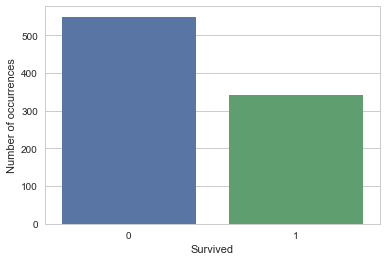

In [7]:
sns.countplot(train.Survived);
plt.xlabel('Survived');
plt.ylabel('Number of occurrences');

In [8]:
#类先验
Survived_count = train.groupby('Survived').size()
p_Survived = Survived_count/float(N_train)
print p_Survived

Survived
0    0.616162
1    0.383838
dtype: float64


## Sex特征，乘客性别（女性乘客更可能生存）
直方图
编码成数值，用于logistic回归
计算类条件概率，用于朴素贝叶斯分类器

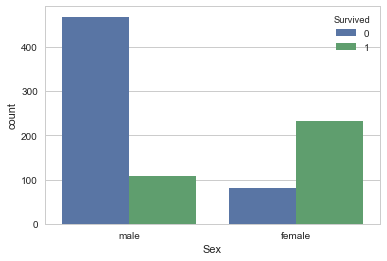

In [9]:
#Sex
sns.countplot(x="Sex", hue="Survived",data=train);

Sex_map = {'female': 1, 'male': 0}
train['Sex'] = train['Sex'].apply(lambda x: Sex_map[x])
test['Sex'] = test['Sex'].apply(lambda x: Sex_map[x])

#还有一种方式是将性别和年龄一起编码为：孩子、老人、男性和女性（老人和小孩是否存和是不考虑性别的）4个哑变量
#对特征的编码可以充分发挥想象

In [10]:
#类条件概率p(sex|surrvivied)

#缺省是sort=true，排序好的
sex_surrvived_count = train[["Sex", "Survived"]].groupby(['Sex','Survived'], as_index=False).size()
print sex_surrvived_count

#fit
p_Sex_Surrvived = np.zeros((2, 2))
# p(sex|surrvivied=0)
p_Sex_Surrvived[0][0] = sex_surrvived_count[0][0]/float(Survived_count[0]) 
p_Sex_Surrvived[0][1] = sex_surrvived_count[1][0]/float(Survived_count[0])
print ('probility sex given not surrvived', p_Sex_Surrvived[0])

# p(sex|surrvivied=1)
p_Sex_Surrvived[1][0] = sex_surrvived_count[0][1]/float(Survived_count[1])
p_Sex_Surrvived[1][1] = sex_surrvived_count[1][1]/float(Survived_count[1])
print ('probility sex given surrvived',p_Sex_Surrvived[1])


#predict
prob_train_NotSurvived['Sex'] = p_Sex_Surrvived[0][train['Sex']]
prob_train_Survived['Sex']= p_Sex_Surrvived[1][train['Sex']]

prob_test_NotSurvived['Sex'] = p_Sex_Surrvived[0][test['Sex']]
prob_test_Survived['Sex']= p_Sex_Surrvived[1][test['Sex']]

Sex  Survived
0    0           468
     1           109
1    0            81
     1           233
dtype: int64
('probility sex given not surrvived', array([ 0.85245902,  0.14754098]))
('probility sex given surrvived', array([ 0.31871345,  0.68128655]))


## Fare特征，船票价格
直方图
本身已是数值型特征
计算类条件概率，用于朴素贝叶斯分类器

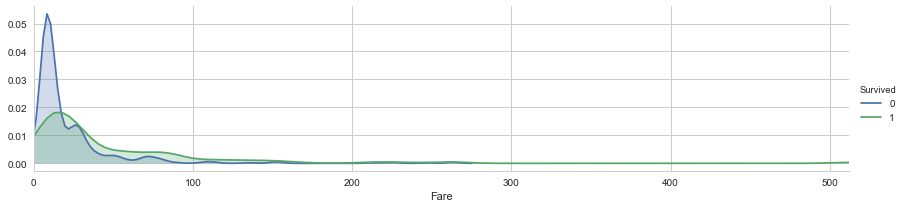

In [11]:
# Fare

# 测试集中有一个缺失值
test["Fare"].fillna(train["Fare"].median(), inplace=True)

# convert from float to int
#train['Fare'] = train['Fare'].astype(int)
#test['Fare']    = test['Fare'].astype(int)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

In [12]:
#看起来不像高斯分布，尾巴长，非单峰,
#用核密度估计试试（高斯核函数，核宽带自动确定）
#from sklearn.neighbors import KernelDensity   (需人工确定核宽度)
from scipy.stats import gaussian_kde

# get fare for survived & didn't survive passengers 
Fare_not_survived = train["Fare"][train["Survived"] == 0]
Fare_survived     = train["Fare"][train["Survived"] == 1]

# Gaussian KDE
#fit
Fare_not_survived_kde = gaussian_kde(Fare_not_survived)
#px = fare_not_survived.sort_values()
#p = fare_not_survived_kde.evaluate(px)
#plt.plot(px,p)
Fare_survived_kde = gaussian_kde(Fare_survived)

#predict
prob_train_NotSurvived['Fare'] = Fare_not_survived_kde.evaluate(train["Fare"])
prob_train_Survived['Fare'] = Fare_survived_kde.evaluate(train['Fare'])

prob_test_NotSurvived['Fare'] = Fare_not_survived_kde.evaluate(test['Fare'])
prob_test_Survived['Fare']=Fare_survived_kde.evaluate(test['Fare'])

## Age特征，乘客年龄
补充缺失值
直方图
本身已是数值型特征
计算类条件概率，用于朴素贝叶斯分类器

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


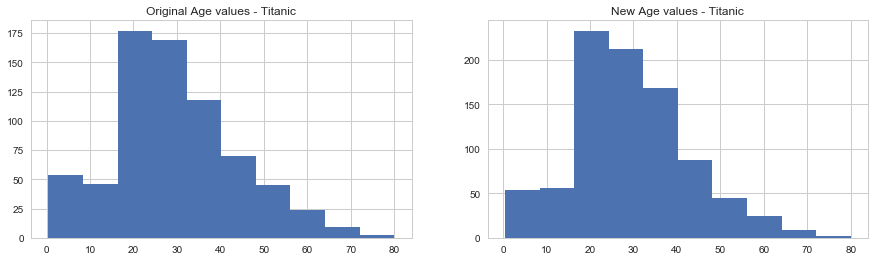

In [13]:
# Age 
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in train
average_age_titanic   = train["Age"].mean()
std_age_titanic       = train["Age"].std()
count_nan_age_titanic = train["Age"].isnull().sum()

# get average, std, and number of NaN values in test
count_nan_age_test = test["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)，都用训练集的信息
#均值附近，1倍标准差内随机生成数据
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
train['Age'].dropna().hist( ax=axis1)
# test['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train["Age"][np.isnan(train["Age"])] = rand_1
test["Age"][np.isnan(test["Age"])] = rand_2

        
# plot new Age Values
train['Age'].hist (ax=axis2)
# test['Age'].hist(bins=70, ax=axis4)

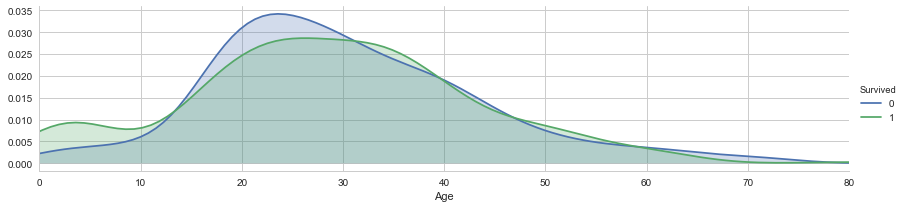

In [14]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

In [15]:
#类条件概率看起来不像高斯分布，尾巴长，非单峰,
#一种方式是将连续变量分组，变成离散变量，以离散变量的方式解决。
#另一种是用核密度估计试试（高斯核函数，核宽带自动确定）
#from sklearn.neighbors import KernelDensity   (需人工确定核宽度)
from scipy.stats import gaussian_kde

# get Age for survived & didn't survive passengers 
Age_not_survived = train["Age"][train["Survived"] == 0]
Age_survived     = train["Age"][train["Survived"] == 1]


# Gaussian KDE
#fit
#fig
Age_not_survived_kde = gaussian_kde(Age_not_survived)
Age_survived_kde = gaussian_kde(Age_survived)

#predict
prob_train_NotSurvived['Age'] = Age_not_survived_kde.evaluate(train['Age'])
prob_train_Survived['Age']= Age_survived_kde.evaluate(train['Age'])

prob_test_NotSurvived['Age'] = Age_not_survived_kde.evaluate(test['Age'])
prob_test_Survived['Age']=Age_survived_kde.evaluate(test['Age'])

## Family特征，是否有家庭成员同船
构造新特征
直方图
本身已是数值型特征
计算类条件概率，用于朴素贝叶斯分类器

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


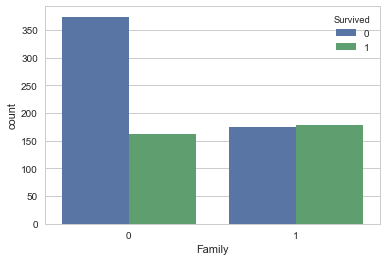

In [16]:
# Family，记录是否有家人同行，同时去掉SibSp和Parch特征
# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
train['Family'] =  train["Parch"] + train["SibSp"]
train['Family'].loc[train['Family'] > 0] = 1
train['Family'].loc[train['Family'] == 0] = 0

test['Family'] =  test["Parch"] + test["SibSp"]
test['Family'].loc[test['Family'] > 0] = 1
test['Family'].loc[test['Family'] == 0] = 0

# drop Parch & SibSp
train = train.drop(['SibSp','Parch'], axis=1)
test    = test.drop(['SibSp','Parch'], axis=1)

#prob_train_NotSurvived.drop(['SibSp','Parch'], axis=1)
#prob_train_Survived.drop(['SibSp','Parch'], axis=1)

#prob_test_NotSurvived.drop(['SibSp','Parch'], axis=1)
#prob_test_Survived.drop(['SibSp','Parch'], axis=1)

sns.countplot(x="Family", hue="Survived",data=train);

In [17]:
#类条件概率p(Family|surrvivied)

#缺省是sort=true，排序好的
Family_surrvived_count = train[["Family", "Survived"]].groupby(['Family','Survived'], as_index=False).size()
print Family_surrvived_count

p_Family_Surrvived = np.zeros((2, 2))
# p(Family|surrvivied=0)
p_Family_Surrvived[0][0] = Family_surrvived_count[0][0]/float(Survived_count[0]) 
p_Family_Surrvived[0][1] = Family_surrvived_count[1][0]/float(Survived_count[0])
print ('probility Family given not surrvived', p_Family_Surrvived[0])

# p(sex|surrvivied=1)
p_Family_Surrvived[1][0] = Family_surrvived_count[0][1]/float(Survived_count[1])
p_Family_Surrvived[1][1] = Family_surrvived_count[1][1]/float(Survived_count[1])
print ('probility sex given surrvived',p_Family_Surrvived[1])


#predict
prob_train_NotSurvived['Family'] = p_Family_Surrvived[0][train['Family']]
prob_train_Survived['Family']= p_Family_Surrvived[1][train['Family']]

prob_test_NotSurvived['Family'] = p_Family_Surrvived[0][test['Family']]
prob_test_Survived['Family']= p_Family_Surrvived[1][test['Family']]

Family  Survived
0       0           374
        1           163
1       0           175
        1           179
dtype: int64
('probility Family given not surrvived', array([ 0.68123862,  0.31876138]))
('probility sex given surrvived', array([ 0.47660819,  0.52339181]))


## Pclass特征，船舱等级
直方图
本身已是数值型特征
计算类条件概率，用于朴素贝叶斯分类器

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64
('probility  Pclass given not surrvived', array([ 0.        ,  0.14571949,  0.17668488,  0.67759563]))
('probility Pclass given surrvived', array([ 0.        ,  0.39766082,  0.25438596,  0.34795322]))


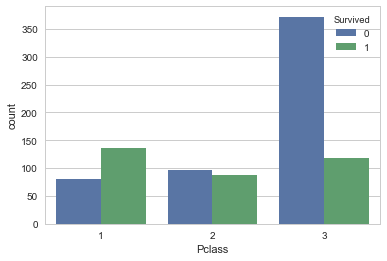

In [18]:
# Pclass
sns.countplot(x="Pclass", hue="Survived",data=train);

#也可与对类别型特征进行哑编码

#类条件概率
#Pclass_surrvived_count = train[["Pclass", "Survived"]].groupby(['Pclass','Survived'], as_index=False).size()
Pclass_surrvived_count =    train[["Pclass",    "Survived"]].groupby(['Pclass',   'Survived'], as_index=False).size()
print Pclass_surrvived_count


p_Pclass_Surrvived = np.zeros((2, 4))

# p(Pclass|surrvivied=0),，注意Pclass_surrvived_count中Pclass值从1开始
p_Pclass_Surrvived[0][1] = Pclass_surrvived_count[1][0]/float(Survived_count[0]) 
p_Pclass_Surrvived[0][2] = Pclass_surrvived_count[2][0]/float(Survived_count[0])
p_Pclass_Surrvived[0][3] = Pclass_surrvived_count[3][0]/float(Survived_count[0])
print ('probility  Pclass given not surrvived', p_Pclass_Surrvived[0])

# p(Pclass|surrvivied=1)
p_Pclass_Surrvived[1][1] = Pclass_surrvived_count[1][1]/float(Survived_count[1])
p_Pclass_Surrvived[1][2] = Pclass_surrvived_count[2][1]/float(Survived_count[1])
p_Pclass_Surrvived[1][3] = Pclass_surrvived_count[3][1]/float(Survived_count[1])
print ('probility Pclass given surrvived',p_Pclass_Surrvived[1])


In [19]:
#predict
prob_train_NotSurvived['Pclass'] = p_Pclass_Surrvived[0][train['Pclass']]
prob_train_Survived['Pclass'] = p_Pclass_Surrvived[1][train['Pclass']]

prob_test_NotSurvived['Pclass'] = p_Pclass_Surrvived[0][test['Pclass']]
prob_test_Survived['Pclass'] = p_Pclass_Surrvived[1][test['Pclass']]

## Embarked特征，登船港口
直方图
编码成数值，用于logistic回归
计算类条件概率，用于朴素贝叶斯分类器

在本任务中我们抛弃该特征，从逻辑上来说从哪个港口登船与是否存活关系不大

In [20]:
train = train.drop(['Embarked'], axis=1)
test = test.drop(['Embarked'], axis=1)

In [21]:
# define training and testing sets
y_train = train["Survived"]
X_train = train.drop("Survived",axis=1)
X_test  = test.drop("PassengerId",axis=1).copy()

In [22]:
# Logistic Regression
logreg = LogisticRegression()

#训练
#对logistic回归，最好将特征标准化，这样使得各特征取值范围相近，从而各系数大小可看出特征的对模型的贡献大小
#如果采用正则化的logistic回归，特征一定要先标准化
#对数据做0均值1方差归一，或者将所有特征取值范围归一到区间【0，1】

logreg.fit(X_train, y_train)

#测试
Y_pred = logreg.predict(X_test)

#训练集上的正确率
logreg.score(X_train, y_train)

0.7912457912457912

In [23]:
#Logistic Regression假设目标与特征之间为线性关系。在本例中，年龄特征与目标之间的关系不满足线性关系，因为老人和孩子生存率都较高，因此效果不好

In [24]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df =  pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Pclass,-1.014924
1,Sex,2.519543
2,Age,-0.025682
3,Fare,0.001627
4,Family,-0.028870


# 作业部分
1. 增加特征或减少特征，模型及其结果有何不同？如增加Embarked特征？去掉Fare特征？
2. 也可以通过增加正则（尤其是L1正则）自动选择合适的特征
3. 对类别型特征Pclass，采用哑编码（one-hot编码），看看模型性能是否改变
4. 对Age和Fare特征可以将其分区间量化，变成类别型编码后，再one-hot编码

In [25]:
# Gaussian Naive Bayes，假设所有类条件分布为高斯分布

# gaussian = GaussianNB()

# gaussian.fit(X_train, Y_train)

# Y_pred = gaussian.predict(X_test)

# gaussian.score(X_train, Y_train)

In [26]:
#自己实现朴素贝叶斯分类器
#http://www.voidcn.com/blog/a_31415926/article/p-1949545.html

#predict on train set
prob_train_NotSurvived['final_prob'] = prob_train_NotSurvived['Pclass']*10*prob_train_NotSurvived['Sex']*10*prob_train_NotSurvived['Family']*10\
                                  *prob_train_NotSurvived['Age']*10*prob_train_NotSurvived['Fare'] *10  * p_Survived[1]
    
prob_train_Survived['final_prob'] = prob_train_Survived['Pclass']*10*prob_train_Survived['Sex']*10*prob_train_Survived['Family']*10\
                                  *prob_train_Survived['Age']*10*prob_train_Survived['Fare']*10 * p_Survived[1]

Y_pred_train = prob_train_Survived['final_prob'] > prob_train_NotSurvived['final_prob']
Y_pred_train.astype(int)

from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, Y_pred_train)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Train Accuary: 75.08%


In [27]:
#predict on test set
prob_test_NotSurvived['final_prob'] = prob_test_NotSurvived['Pclass']*10*prob_test_NotSurvived['Sex']*10*prob_test_NotSurvived['Family']*10\
                                  *prob_test_NotSurvived['Age']*10*prob_test_NotSurvived['Fare'] *10  * p_Survived[0]
    
prob_test_Survived['final_prob'] = prob_test_Survived['Pclass']*10*prob_test_Survived['Sex']*10*prob_test_Survived['Family']*10\
                                  *prob_test_Survived['Age']*10*prob_test_Survived['Fare']*10 * p_Survived[1]

Y_pred = prob_test_Survived['final_prob'] > prob_test_NotSurvived['final_prob']
Y_pred.astype(int)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     0
18     0
19     0
20     1
21     0
22     1
23     1
24     1
25     0
26     1
27     0
28     0
29     0
      ..
388    0
389    0
390    1
391    1
392    0
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    1
401    0
402    1
403    0
404    0
405    0
406    0
407    1
408    0
409    1
410    0
411    1
412    0
413    0
414    1
415    0
416    0
417    0
Name: final_prob, dtype: int64

In [28]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

In [29]:
# Embarked

# 训练集中有2个样本的值缺失，用登船人数最多的码头 "S"填充.
train["Embarked"] = train["Embarked"].fillna("S")

# plot
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=train, ax=axis1)

sns.countplot(x='Survived', hue="Embarked", data=train, order=[1,0], ax=axis2)

prob_embark_survived = train[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
#print prob_embark_survived

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'], ax=axis3)


# 对类别型变量进行数字编码：通过观察，C的存活率最高，编码为2，S的存活率最低，编码为1，使得目标与Embarked特征之间正相关 
#Embarked_map = {'C': 2, 'Q': 1, 'S': 0}
#train['Embarked'] = train['Embarked'].apply(lambda x: Embarked_map[x])
#train['Embarked'] = train['Embarked'].apply(lambda x: Embarked_map[x])

# 或者可以去掉，因为从逻辑上看，从哪个港口登船应该和存活率没有太大关系
train = train.drop(['Embarked'], axis=1)
test = test.drop(['Embarked'], axis=1)

#prob_train_NotSurvived.drop(['Embarked'], axis=1)
#prob_train_Survived.drop(['Embarked'], axis=1)

#prob_test_NotSurvived.drop(['Embarked'], axis=1)
#prob_test_Survived.drop(['Embarked'], axis=1)

KeyError: 'Embarked'